<a href="https://colab.research.google.com/github/githubpradeep/notebooks/blob/main/meme_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
import torch


In [ ]:
!pip install flamingo-pytorch

In [ ]:
!pip install vit-pytorch

In [3]:
!git clone https://github.com/dhansmair/flamingo-mini.git


Cloning into 'flamingo-mini'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 305 (delta 90), reused 68 (delta 68), pack-reused 203
Receiving objects: 100% (305/305), 1.40 MiB | 18.80 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [ ]:
%cd flamingo-mini
!pip install .

In [ ]:
from flamingo_mini import FlamingoConfig, FlamingoModel, FlamingoProcessor

model = FlamingoModel.from_pretrained('dhansmair/flamingo-mini')           # or flamingo-tiny
processor = FlamingoProcessor(model.config)

In [8]:
model=model.to('cuda')


In [ ]:
model.eval()

In [12]:
import torch
from flamingo_mini import FlamingoModel, FlamingoProcessor
from flamingo_mini.utils import load_url
device='cuda'

# load and process an example image
print('loading image and generating caption...')
image = load_url('https://raw.githubusercontent.com/rmokady/CLIP_prefix_caption/main/Images/CONCEPTUAL_02.jpg')
caption = model.generate_captions(processor, images=[image], device=device)
print('generated caption:', caption[0])

loading image and generating caption...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


generated caption: tourists under the cherry blossoms


In [20]:
from einops import repeat

def multimodal_prompt(model: FlamingoModel, processor: FlamingoProcessor, prompt: str, images: list, device: torch.device) -> str:
    """few-shot multimodal prompting

    shape for visual_features parameter: [b=batch size, N=number of images, T=1 (number of frames), v=number of visual features, d=dimensionality of visual feature]
    (I haven't checked if it works with videos)
    """
    input_ids, media_locations, attention_mask = processor.encode_text(prompt, device=device)

    pixels = processor(images, device=device)['pixel_values']
    pixels = repeat(pixels, 'N c h w -> b N T c h w', b=1, T=1)

    output = model.generate(
        inputs=input_ids,
        media_locations=media_locations,
        attention_mask=attention_mask,
        pixel_values=pixels,
        max_length=150,
        use_cache=True,
        early_stopping=True,
        bos_token_id=model.flamingo.lm.config.bos_token_id,
        eos_token_id=model.flamingo.lm.config.eos_token_id,
        pad_token_id=model.flamingo.lm.config.eos_token_id
    )

    response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)
    return response[0]

In [222]:
prompt = "<image> A photo of"
response = multimodal_prompt(model, processor, prompt, images=[image], device=device)
print('prompt:', prompt)
print('output:', response)

prompt: <image> A photo of
output: <image> A photo of the cherry blossoms<EOC>


In [41]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install langchain cohere

In [44]:
from langchain.llms import Cohere
from langchain import PromptTemplate, LLMChain

In [45]:
COHERE_API_KEY="uvXiXk8Lp852cebj690CC2E2O8oG5ZeSmGRUn6dH"

In [46]:
llm = Cohere(cohere_api_key=COHERE_API_KEY)

In [191]:
import os, sys
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops

from PIL import Image, ImageChops
class Image_Manager:
    def __init__(self):
        print("Image manager create")

    @staticmethod
    def add_text(
        base,
        text,
        position,
        font_size,
        text_color="black",
        text_width_proportion=4,
        wrapped_width=None,
        rotate_degrees=None,
    ):

        try:
            overlay_image = Image.new("RGBA", base.size, (0, 0, 0, 0))
            font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)

            draw = ImageDraw.Draw(overlay_image)
            fill = (0, 0, 0, 255)
            if text_color == "white":
                fill = (255, 255, 255, 255)
            lines = textwrap.wrap(text, width=20)
            w, h = 0 , 0
            y_text = position[1]
            for line in lines:
                width, height = font.getsize(line)
                draw.text((position[0], y_text), line, font=font, fill=fill)
                y_text += height
            #draw.text(position, text, font=font, fill=fill)


            if rotate_degrees is not None:
                overlay_image = overlay_image.rotate(rotate_degrees)

            return overlay_image
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(f"error: {e}")
            print(f"line: {exc_tb.tb_lineno}")
            print(f"file: {fname}")
            return "error"


In [192]:
import datetime
import textwrap


In [214]:
def make_meme(image_url, text_color='black', meme_text='', position=(10,20)):
  image = load_url(image_url)
  prompt = "<image> A photo of"
  response = multimodal_prompt(model, processor, prompt, images=[image], device=device)
  print('prompt:', prompt)
  if meme_text:
    response = meme_text
  print('output:', response)
  text = llm("write a one line meme about " + response)
  print(text)
  with image.convert(
            "RGBA"
        ) as base:
        base = base.resize((300, 300))

        overlay_image = Image_Manager.add_text(
            base=base,
            text=text,
            position=position,
            font_size=15,
            text_color=text_color,
            rotate_degrees=0,
            wrapped_width=22,
        )

        out = Image.alpha_composite(base, overlay_image)
        if out.mode in ("RGBA", "P"):
            out = out.convert("RGB")
            date = datetime.datetime.now()
            image_name = f"{date}.jpg"
            file_location = f"{image_name}"
            out.save(file_location)
  return out

prompt: <image> A photo of
output: <image> A photo of a cat wearing glasses<EOC>
 The future is meow-n.


<ipython-input-155-42e9e387ca4a>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


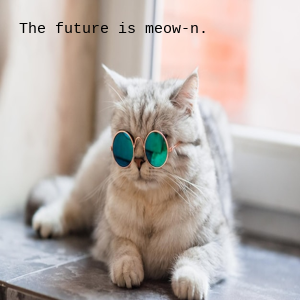

In [158]:
make_meme('https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg')

prompt: <image> A photo of
output: <image> A photo of a cat with its mouth open<EOC>
 "Cat got your tongue?"


<ipython-input-155-42e9e387ca4a>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


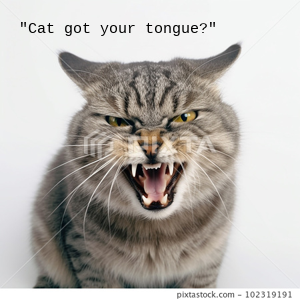

In [159]:
make_meme('https://en.pimg.jp/102/319/191/1/102319191.jpg')

prompt: <image> A photo of
output: <image> A photo of a cat with a sad face<EOC>
 Meow-me-down!


<ipython-input-155-42e9e387ca4a>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


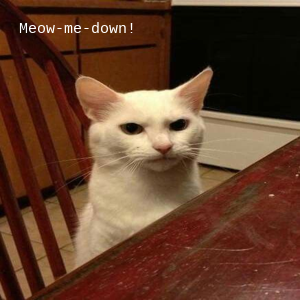

In [173]:
make_meme('https://i.pinimg.com/1200x/64/6b/af/646baf16ffbcc38037dfa7bfb79a9fa8.jpg', text_color='white')

prompt: <image> A photo of
output: <image> A photo of a man pointing at his head and smiling<EOC>
 I can't help but notice you're not very smart.


<ipython-input-155-42e9e387ca4a>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


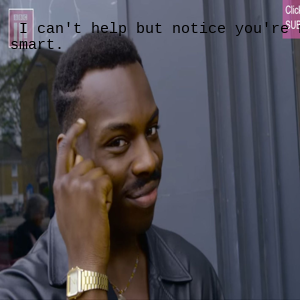

In [181]:
make_meme('https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.2x.h473.w710.jpg')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


prompt: <image> A photo of
output: one does not 


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.


One does not simply walk into Mordor.


<ipython-input-191-960c4d49deef>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


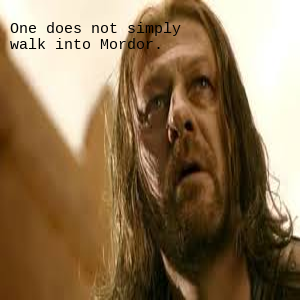

In [207]:
make_meme('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTlJ87Er8TuCjEY9jn5aYGUR8kwPxKEF5-MvQ&usqp=CAU', meme_text='one does not ')

prompt: <image> A photo of
output: i am
 "I am the best. Period."


<ipython-input-191-960c4d49deef>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


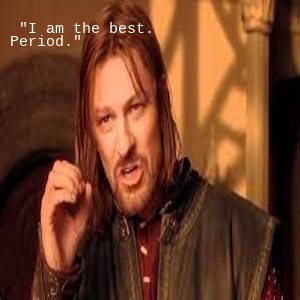

In [210]:
make_meme('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFW2XM9K7CYjvDirQxTQQCdi9JUxWiAyi7pg&usqp=CAU',
          text_color='white',
          meme_text = 'i am')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


prompt: <image> A photo of
output: <image> A photo of a girl with a long, curly hair<EOC>
 "I'm not saying I'm Wonder Woman, but I could be."


<ipython-input-191-960c4d49deef>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


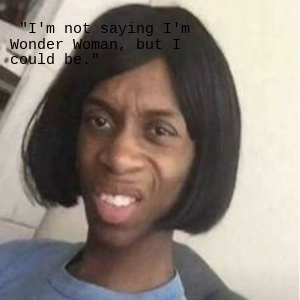

In [211]:
make_meme('https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg')

prompt: <image> A photo of
output: <image> A photo of a man holding a sign that says we're not all like the pope<EOC>
 "Not all of us are like the Pope, but we can still be a bunch of jerks."


<ipython-input-191-960c4d49deef>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


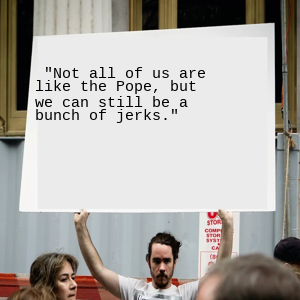

In [220]:
make_meme('https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lHZawDQbub5zYAOmmEYUEg.jpeg', position=(35,65))

In [238]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

class Meme:

    basewidth = 1200             #Width to make the meme
    fontBase = 100
    letSpacing = 9              #Space between letters
    fill = (255, 255, 255)      #TextColor
    stroke_fill = (0,0,0)             #outlineColor
    lineSpacing = 10            #Space between lines
    stroke_width=9              #How thick the outline of the text is
    fontfile = font = '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf'

    def __init__(self, caption, image):
        self.img = self.createImage(image)
        self.d = ImageDraw.Draw(self.img)

        self.splitCaption = textwrap.wrap(caption, width=20)  # The text can be wider than the img. If thats the case split the text into multiple lines
        self.splitCaption.reverse()                           # Draw the lines of text from the bottom up

        fontSize = self.fontBase+10 if len(self.splitCaption) <= 1 else self.fontBase   #If there is only one line, make the text a bit larger
        self.font = ImageFont.truetype(font=self.fontfile, size=fontSize)
        # self.shadowFont = ImageFont.truetype(font='./impact.ttf', size=fontSize+10)

    def draw(self):
        '''
        Draws text onto this objects img object
        :return: A pillow image object with text drawn onto the image
        '''
        (iw, ih) = self.img.size
        (_, th) = self.d.textsize(self.splitCaption[0], font=self.font) #Height of the text
        y = (ih - (ih / 10)) - (th / 2) #The starting y position to draw the last line of text. Text in drawn from the bottom line up

        for cap in self.splitCaption:   #For each line of text
            (tw, _) = self.d.textsize(cap, font=self.font)  # Getting the position of the text
            x = ((iw - tw) - (len(cap) * self.letSpacing))/2  # Center the text and account for the spacing between letters

            self.drawLine(x=x, y=y, caption=cap)
            y = y - th - self.lineSpacing  # Next block of text is higher up

        wpercent = ((self.basewidth/2) / float(self.img.size[0]))
        hsize = int((float(self.img.size[1]) * float(wpercent)))
        return self.img.resize((int(self.basewidth/2), hsize))

    def createImage(self, image):
        '''
        Resizes the image to a resonable standard size
        :param image: Path to an image file
        :return: A pil image object
        '''
        img = image
        wpercent = (self.basewidth / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        return img.resize((self.basewidth, hsize))

    def drawLine(self, x, y, caption):
        '''
        The text gets split into multiple lines if it is wider than the image. This function draws a single line
        :param x: The starting x coordinate of the text
        :param y: The starting y coordinate of the text
        :param caption: The text to write on the image
        :return: None
        '''
        for idx in range(0, len(caption)):  #For each letter in the line of text
            char = caption[idx]
            w, h = self.font.getsize(char)  #width and height of the letter
            self.d.text(
                (x, y),
                char,
                fill=self.fill,
                stroke_width=self.stroke_width,
                font=self.font,
                stroke_fill=self.stroke_fill
            )  # Drawing the text character by character. This way spacing can be added between letters
            x += w + self.letSpacing #The next character must be drawn at an x position more to the right




In [239]:
def make_meme(image_url, text_color='black', meme_text='', position=(10,20)):
  image = load_url(image_url)
  prompt = "<image> A photo of"
  response = multimodal_prompt(model, processor, prompt, images=[image], device=device)
  print('prompt:', prompt)
  if meme_text:
    response = meme_text
  print('output:', response)
  text = llm("write a one line meme about " + response)
  print(text)
  meme = Meme(text, image)
  img = meme.draw()
  return img

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


prompt: <image> A photo of
output: <image> A photo of a girl with a long, curly hair<EOC>
 "I love my long, curly hair!"


<ipython-input-238-542f2f0b4a25>:32: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  (_, th) = self.d.textsize(self.splitCaption[0], font=self.font) #Height of the text
<ipython-input-238-542f2f0b4a25>:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  (tw, _) = self.d.textsize(cap, font=self.font)  # Getting the position of the text
<ipython-input-238-542f2f0b4a25>:67: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  w, h = self.font.getsize(char)  #width and height of the letter
<ipython-input-238-542f2f0b4a25>:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  (tw, _) = self.d.textsize(cap, font=self.font)  # Getting the position of the text
<ipython-input-238-542f2f0b4a

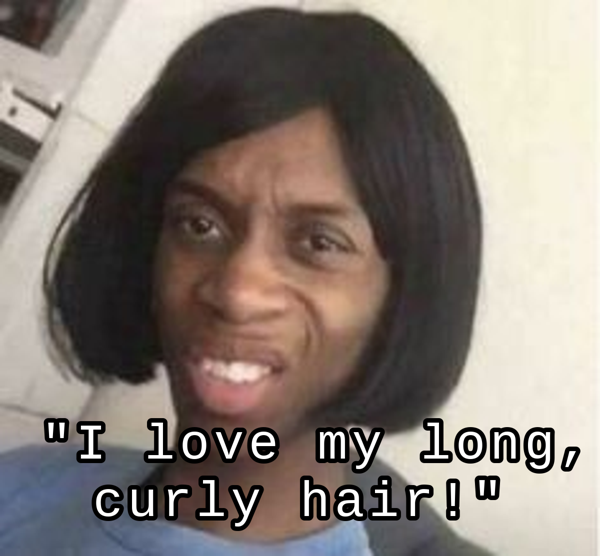

In [240]:
make_meme('https://i.pinimg.com/236x/31/d0/b1/31d0b18d404474209df237896a435caf.jpg')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


prompt: <image> A photo of
output: <image> A photo of a man pointing at his head and smiling<EOC>
 Who's the guy pointing at his head?


<ipython-input-238-542f2f0b4a25>:32: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  (_, th) = self.d.textsize(self.splitCaption[0], font=self.font) #Height of the text
<ipython-input-238-542f2f0b4a25>:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  (tw, _) = self.d.textsize(cap, font=self.font)  # Getting the position of the text
<ipython-input-238-542f2f0b4a25>:67: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  w, h = self.font.getsize(char)  #width and height of the letter
<ipython-input-238-542f2f0b4a25>:36: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  (tw, _) = self.d.textsize(cap, font=self.font)  # Getting the position of the text
<ipython-input-238-542f2f0b4a

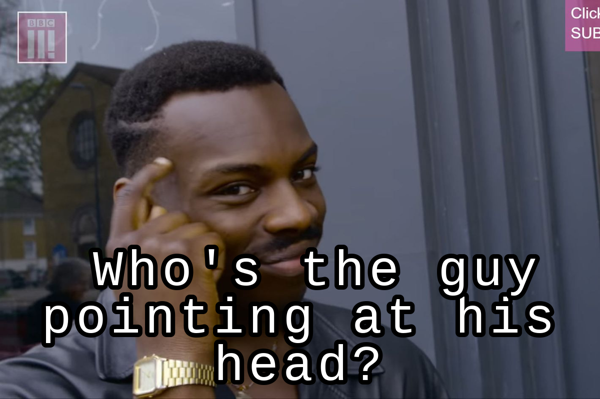

In [241]:
make_meme('https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.2x.h473.w710.jpg')